# Project description
Urban mobility significantly contributes to global environmental impact. With the growth in urbanareas worldwide, cities are implementing policies to focus on sustainable urban and mobility devel-opment. Urban areas exhibit high variability in structure, economic output, mobility behaviour,among others. Pinpointing to the exact causes of emissions is impossible. However, understandingthe relationship of mobility with infrastructure resources and other urban indicators may help gov-ernments predict long-term mobility behaviour and intervene with future pathways into sustainablemobility options. </br>

Project goals: You are tasked to identify how mobility is related to the infrastructural form of acity and across multiple cities. Use your findings toward helping governments transform mobilitywithin cities for reducing environmental impacts of mobility use.
Data: </br>
1. Local city-wide indicators of urban mobility: Multi-city Traffic Datasetprovided publicly byThe Institute for Transport Planning and Systems at ETH Zurich.
2. Global city-wide indicators of urban mobility and environmental impacts:Urban TypologiesProject[Reference]3.Get indicators for infrastructure resources from OSMNX (street networks) and PYROSM(amenities and points of interest) python packages.High-level project goals1.Explore, Investigate, and Visualize various factors of the mobility data across cities of interest.2.Describe and incorporate additional data sources that you will use to help you understandrelationships between mobility and the built environment.
3. Identify correlations between mobility and the built environment.4.Perform clustering or LISA analysis on city streets where congestion may be related stronglywith the presence of certain amenities. Think about how that may vary with distance toamenities.
4. Or, train and evaluate models using the mobility data (either as predictors or as the primaryresponse in some fashion) and your data sources.
6. Use and interpret your models to discuss the causes and correlations of or effects due todifferences in congestion across cities or within a city of your choice.
7. Aggregate city-wide findings to correlate with environmental indicators used in data set (2) -urban typology - to comment on policy initiatives of the governments. (Think how you mayaggregate city-wide findings to a single score for the whole city to compare with indicatorsused in data set 

(2))Note: Not all data may be available for all cities. Hence, conduct this analysis for at least5citiesoverlapping between sets1and2in the data. You are welcome to do the analysis in many morecities.


### UTD-19

### OSMNX

In [2]:
# import 
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pyrosm as py
import seaborn as sns

In [3]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe

<AxesSubplot:xlabel='long', ylabel='lat'>

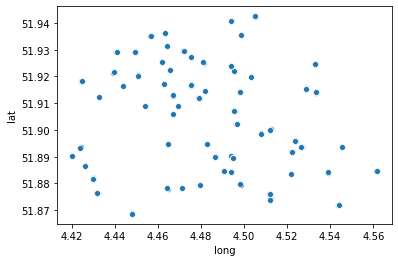

In [4]:
df2 = UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam']
sns.scatterplot(x = 'long', y = 'lat', data = df2)

In [5]:
df2.head()
#len (df2.road.unique())

,detid,length,pos,fclass,road,limit,citycode,lanes,linkid,long,lat
16321,GRT02_MORO_1811_2_1,0.373911,0.307366,secondary,Kreekhuizenlaan,50,rotterdam,1.0,100.0,4.539146,51.884051
16322,GRT02_MORO_1822_2_1,1.041926,0.533046,secondary,Groeninx van Zoelenlaan,80,rotterdam,1.0,90.0,4.561430,51.884623
16323,GRT02_MORO_1293_2_1,0.168822,0.074032,secondary,Schiekade,50,rotterdam,1.0,47.0,4.475207,51.927265
16324,GRT02_MORO_1293_2_2,0.168822,0.074032,secondary,Schiekade,50,rotterdam,1.0,47.0,4.475207,51.927265
16325,GRT02_MORO_1851_2_1,0.589675,0.148455,trunk,Vaanweg,50,rotterdam,1.0,96.0,4.512462,51.874034


### OSMNX Graph creation

In [6]:
def GetGraphs(clist, df):
    # function designed to extract bbox and create graphs with bbox
    GraphList = []
    for i in clist:
        maxlonglt = df.loc[df.citycode == i, ['long', 'lat']].max() # maxlonglat[0] = long, 1 lat
        minlonglt = df.loc[df.citycode == i, ['long', 'lat']].min() #
        north = maxlonglt[1] 
        south = minlonglt[1]
        east = maxlonglt[0]
        west = minlonglt[0]
        A = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')
        GraphList.append(A)
    return GraphList
        
Graphs = GetGraphs(newcitylist, UTD19Cities)

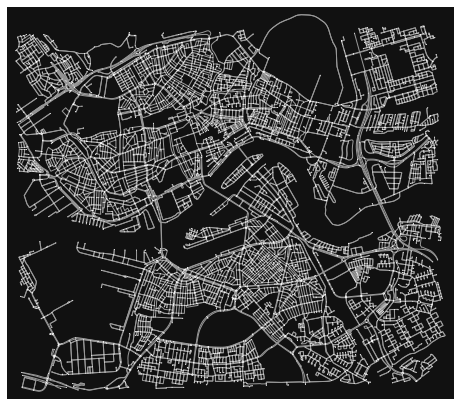

In [7]:
# example of plotting a graph
G1 = ox.project_graph(Graphs[1])
fig, ax = ox.plot_graph(G1, node_size=1)

In [8]:
# Edge attributes and node data
Rotterdam = Graphs[1]
node_data, edge_attributes = ox.graph_to_gdfs(Rotterdam) # Get node info and edge info

NameLink = pd.DataFrame(edge_attributes[['osmid','name']]) # only extract the osmid and road name
NameLink.rename({'name': 'road'}, inplace = True, axis = 1) # The Graph network has more raods in it than UTD
# some entries are a list of street names 
NameLink = NameLink.explode('road') # use this to create entry with same values, so road is not a list anymore
#NameLink = NameLink.explode('osmid') # some roads have two osmid -> explode

URotterdam = UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam', ['detid', 'road']] #only get detid and road name

TranslateTable = pd.merge(NameLink, URotterdam, on = 'road', how = 'right')
TranslateTable.head() # links osmid and detid

edge_attributes

,osmid,name,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key
0,"[311806104, 311806106, 321898179]",'s-Gravenweg,residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0
1,7514536,Frans Bekkerstraat,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0
2,7515679,Frans Bekkerstraat,residential,False,76.835,NaN,"LINESTRING (4.46527 51.89180, 4.46496 51.89218...",50,NaN,NaN,NaN,NaN,NaN,44269570,963879003,0
3,"[7515714, 7515628]",Verboomstraat,residential,False,145.552,NaN,"LINESTRING (4.46527 51.89180, 4.46528 51.89177...",50,NaN,NaN,NaN,NaN,NaN,44269570,44262667,0
4,7319072,Schultz van Hagenstraat,residential,False,48.438,NaN,"LINESTRING (4.52872 51.92385, 4.52848 51.92344)",NaN,NaN,NaN,NaN,NaN,NaN,44417028,44412933,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17153,7513502,Putselaan,residential,True,74.466,NaN,"LINESTRING (4.50077 51.89826, 4.50060 51.89831...",NaN,NaN,NaN,NaN,NaN,NaN,735821821,735821808,0
17154,"[494919621, 7513646]",Putselaan,secondary,True,269.995,NaN,"LINESTRING (4.50077 51.89826, 4.49987 51.89819...",50,3,S120,NaN,NaN,NaN,735821821,4801683177,0
17155,7515716,Kesterenstraat,unclassified,False,31.071,NaN,"LINESTRING (4.45556 51.89186, 4.45522 51.89205)",NaN,NaN,NaN,NaN,NaN,NaN,44269566,44270495,0
17156,7515718,NaN,unclassified,False,21.159,NaN,"LINESTRING (4.45556 51.89186, 4.45563 51.89205)",NaN,NaN,NaN,NaN,NaN,NaN,44269566,44270498,0


In [ ]:
# way to add colors to edges
x = [1 if x%2 == 0 else 0 for x in edge_attributes.index] # create some random atribute

edge_attributes['X']=x # set att

WithX = ox.graph_from_gdfs(node_data, edge_attributes, graph_attrs={'edge_attr':'X'}) # graph_attrs and edge works it is safed! and able to call back
WithX.graph['crs'] = Rotterdam.graph['crs'] # need crs to plot
ec = ox.plot.get_edge_colors_by_attr(WithX, attr='length', cmap='viridis') # set color scale by atribute (now length could be any other variable)

G1 = ox.project_graph(WithX)
fig, ax = ox.plot_graph(G1, node_size=1, edge_color=ec) # edgecolor is stored in ec

# Urban typologies import


In [4]:
citylist = ['Munich', 'Rotterdam-Hague', 'Frankfurt', 'Hamburg', 'Zurich']
UrbanTypo = pd.read_excel('Data/FINAL-COMBINED-DATASET.xlsx')
Cities = UrbanTypo.loc[(UrbanTypo.City.isin(citylist))]
Cities.reset_index(inplace = True)
Cities.head()

,index,City,cityID,clusterID,Typology,Country,Car Modeshare (%),Public Transit Modeshare (%),Bicycle Modeshare (%),Walking Modeshare (%),...,Highway Proportion,Metro Propensity Factor,BRT Propensity Factor,BikeShare Propensity Factor,Development Factor,Sustainability Factor,Population Factor,Congestion Factor,Sprawl Factor,Network Density Factor
0,98,Hamburg,99,9,MassTransit Heavyweight,Germany,42.00,18.00,12,28.00,...,0.016812,0.667477,0.273596,0.437481,0.747204,0.536597,0.035424,0.357805,0.313441,0.231415
1,99,Munich,100,9,MassTransit Heavyweight,Germany,37.00,21.00,14,28.00,...,0.021030,0.674947,0.142531,0.433690,0.779353,0.599366,0.033533,0.354032,0.236366,0.429755
2,101,Frankfurt,102,10,MassTransit Moderate,Germany,38.00,20.00,11,31.00,...,0.033763,0.080828,0.131759,0.403807,0.741574,0.625617,0.044672,0.323014,0.323657,0.342305
3,182,Rotterdam-Hague,183,10,MassTransit Moderate,Netherlands,49.00,17.00,16,18.00,...,NaN,0.356458,0.164029,0.484939,0.750362,0.540186,0.035450,0.204339,0.193488,0.508605
4,238,Zurich,239,10,MassTransit Moderate,Switzerland,42.92,46.31,4.14,5.65,...,0.025206,0.090735,0.346604,0.163072,1.000000,0.575431,0.025346,0.388853,0.185876,0.453369


# Fabians Merge

In [28]:
Rotterdam = Graphs[1]
node_data, edge_attributes = ox.graph_to_gdfs(Rotterdam) # Get node info and edge info
#switch first and second column
colnames=[]
for i, names in enumerate(edge_attributes.columns):
    colnames.append(names)
colnames[0]='name'
colnames[1]='osmid'
#print(colnames)
edge_attributes=edge_attributes.reindex(columns=colnames)
edge_attributes.head()

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key
0,'s-Gravenweg,"[311806104, 311806106, 321898179]",residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0
1,Frans Bekkerstraat,7514536,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0
2,Frans Bekkerstraat,7515679,residential,False,76.835,NaN,"LINESTRING (4.46527 51.89180, 4.46496 51.89218...",50,NaN,NaN,NaN,NaN,NaN,44269570,963879003,0
3,Verboomstraat,"[7515714, 7515628]",residential,False,145.552,NaN,"LINESTRING (4.46527 51.89180, 4.46528 51.89177...",50,NaN,NaN,NaN,NaN,NaN,44269570,44262667,0
4,Schultz van Hagenstraat,7319072,residential,False,48.438,NaN,"LINESTRING (4.52872 51.92385, 4.52848 51.92344)",NaN,NaN,NaN,NaN,NaN,NaN,44417028,44412933,0


In [30]:
dfea=edge_attributes#chiller, want korter
dfea.loc[:,['name']]=np.nan_to_num(dfea.loc[:,['name']])

#create list to log whether a row contains a list for osmid
listornot=[]
for i in range(len(dfea.name)):
    if type(dfea.iloc[i,0]) == list:
        listornot.append(True)
    else:
        listornot.append(False)
#now append to df!
dfea['list?']=listornot
dfea.head(2)

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key,list?
0,'s-Gravenweg,"[311806104, 311806106, 321898179]",residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0,False
1,Frans Bekkerstraat,7514536,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0,False


In [60]:
#save lists 
dfea_lists=dfea.loc[(dfea['list?'] == True)]
#save nonlists
dfea_nonlists=dfea.loc[(dfea['list?'] == False)]
dfea_lists=dfea_lists.reset_index()
#dfea_lists.drop(['index'])
dfea_lists=dfea_lists.iloc[:,1:17]
dfea_lists.shape

(649, 16)

In [64]:
#thrid try, also put appends in loop.
cdict = {name: [] for name in (dfea_lists.columns)} #make dict that consists out of lists equal to columns of df to fill below, with right names

for i in range (len(dfea_lists.name)):
    for j in range(len(dfea_lists.name[i])):
        ab=dfea_lists.name[i]
        cdict['name'].append(ab[j])
        for k, names_to_append in enumerate(dfea_lists.columns[1:len(dfea_lists.columns)]):
            l=k+1
            cdict[names_to_append].append(dfea_lists.iloc[i,l])
        
dfnew=pd.DataFrame.from_dict(cdict)
dfnew.head(2)
#works! 

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key
0,Martinus Burkensstraat,"[7315045, 7314958]",residential,False,127.547,NaN,"LINESTRING (4.5525434 51.9238523, 4.5526111 51...",NaN,NaN,NaN,NaN,NaN,NaN,44417036,44421114,0
1,Pieter van der Wallenstraat,"[7315045, 7314958]",residential,False,127.547,NaN,"LINESTRING (4.5525434 51.9238523, 4.5526111 51...",NaN,NaN,NaN,NaN,NaN,NaN,44417036,44421114,0


In [104]:
dfea_nonlists.reset_index(inplace = True, drop = True)
dfnew.reset_index(inplace=True, drop = True)
frames=[dfea_nonlists,dfnew]
final_set=pd.concat(frames)
final_set.head() # this is the final mergable set

,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key,list?
0,'s-Gravenweg,"[311806104, 311806106, 321898179]",residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0,False
1,Frans Bekkerstraat,7514536,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0,False
2,Frans Bekkerstraat,7515679,residential,False,76.835,NaN,"LINESTRING (4.46527 51.89180, 4.46496 51.89218...",50,NaN,NaN,NaN,NaN,NaN,44269570,963879003,0,False
3,Verboomstraat,"[7515714, 7515628]",residential,False,145.552,NaN,"LINESTRING (4.46527 51.89180, 4.46528 51.89177...",50,NaN,NaN,NaN,NaN,NaN,44269570,44262667,0,False
4,Schultz van Hagenstraat,7319072,residential,False,48.438,NaN,"LINESTRING (4.52872 51.92385, 4.52848 51.92344)",NaN,NaN,NaN,NaN,NaN,NaN,44417028,44412933,0,False


<AxesSubplot:xlabel='x', ylabel='y'>

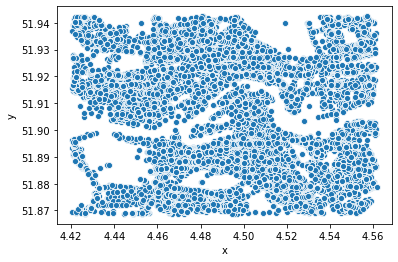

In [156]:
#Testing
final_set['x'] = final_set.geometry.centroid.x
final_set['y'] = final_set.geometry.centroid.y

sns.scatterplot('x', 'y', data = final_set)

In [198]:
# try merge?
TranslateTable.rename({'road':'name'}, inplace = True, axis =1)

#new_edges = final_set.merge(TranslateTable, on = 'name', how = 'right')
#new_edges.drop(['osmid_y', 'list?'], inplace = True, axis =1)
#new_edges.rename({'osmid_x': 'osmid'}, inplace = True, axis =1)
# 48400943
#new_edges.head(2)
#TranslateTable.name.dropna(inplace = True)
TranslateTable.set_index(TranslateTable.name, inplace = True, drop = True)
TranslateTable.head()

,osmid,name,detid
name,,,
Kreekhuizenlaan,48400943,Kreekhuizenlaan,GRT02_MORO_1811_2_1
Kreekhuizenlaan,7326948,Kreekhuizenlaan,GRT02_MORO_1811_2_1
Kreekhuizenlaan,7326613,Kreekhuizenlaan,GRT02_MORO_1811_2_1
Kreekhuizenlaan,7326943,Kreekhuizenlaan,GRT02_MORO_1811_2_1
Kreekhuizenlaan,7326613,Kreekhuizenlaan,GRT02_MORO_1811_2_1


In [200]:
new_edges = final_set[final_set.name.isin(TranslateTable.name)]
new_edges.shape

(1999, 19)

In [195]:
# df = df[~df.datecolumn.isin(a)] idea

new_edges = final_set[~final_set.name.isin(TranslateTable.name)] # take only the edges of which the name is in translate table
new_edges.drop('list?', inplace = True, axis =1)
new_edges.reset_index(inplace = True, drop = True)

new_edges.head()

C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,name,osmid,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key,x,y
0,'s-Gravenweg,"[311806104, 311806106, 321898179]",residential,False,88.311,yes,"LINESTRING (4.52452 51.92392, 4.52412 51.92331...",NaN,NaN,NaN,NaN,NaN,NaN,44417024,771255062,0,4.524278,51.923550
1,Frans Bekkerstraat,7514536,residential,False,61.119,NaN,"LINESTRING (4.46527 51.89180, 4.46613 51.89165)",NaN,NaN,NaN,NaN,NaN,NaN,44269570,44269098,0,4.465702,51.891726
2,Frans Bekkerstraat,7515679,residential,False,76.835,NaN,"LINESTRING (4.46527 51.89180, 4.46496 51.89218...",50,NaN,NaN,NaN,NaN,NaN,44269570,963879003,0,4.465025,51.892107
3,Verboomstraat,"[7515714, 7515628]",residential,False,145.552,NaN,"LINESTRING (4.46527 51.89180, 4.46528 51.89177...",50,NaN,NaN,NaN,NaN,NaN,44269570,44262667,0,4.464929,51.891187
4,Schultz van Hagenstraat,7319072,residential,False,48.438,NaN,"LINESTRING (4.52872 51.92385, 4.52848 51.92344)",NaN,NaN,NaN,NaN,NaN,NaN,44417028,44412933,0,4.528603,51.923644


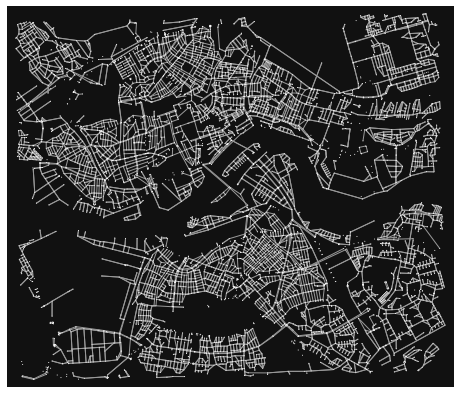

In [86]:
# Creation of grahp
RotterdamII = ox.graph_from_gdfs(node_data, new_edges)
#new_edges.shape
#edge_attributes.shape
G1 = ox.project_graph(RotterdamII)
fig, ax = ox.plot_graph(G1, node_size=1)


### PYROSM Points of Interest

In [114]:
# de filepaths zin nu specifiek voor mijn computer, moet je zelf even aanpassen naar waar die van jou staan
fp_rotterdam ="data/rotterdam.osm.pbf"
fp_munich ="data/munich.osm.pbf"
fp_zurich ="data/zurich.osm.pbf"
fp_hamburg ="data/hamburg.osm.pbf"
fp_frankfurt ="data/frankfurt.osm.pbf"

C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\pyrosm\pois.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None,
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\pyrosm\pois.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None,
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\pyrosm\pois.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

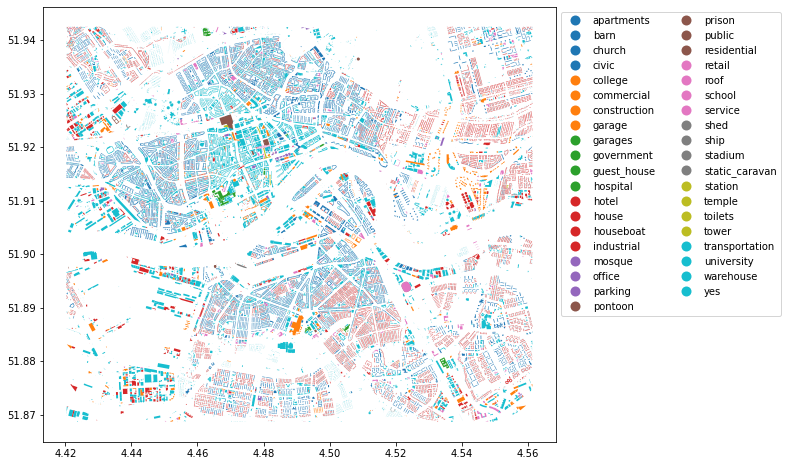

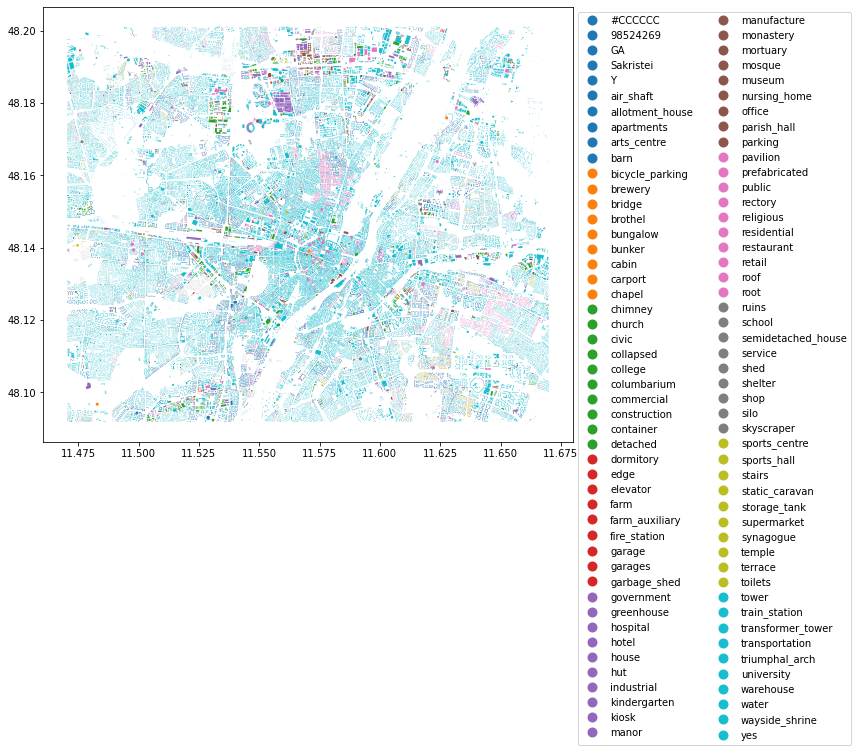

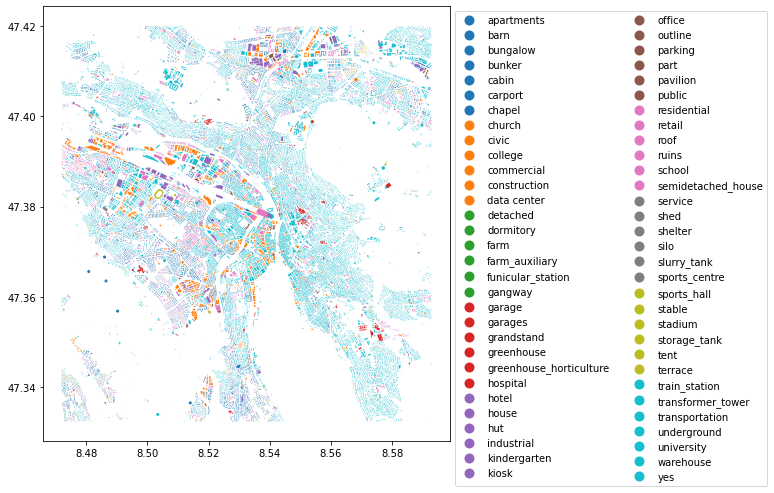

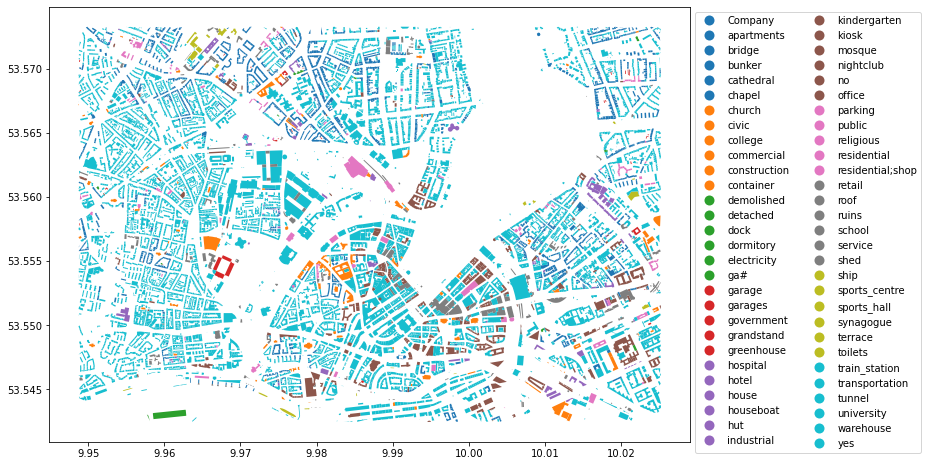

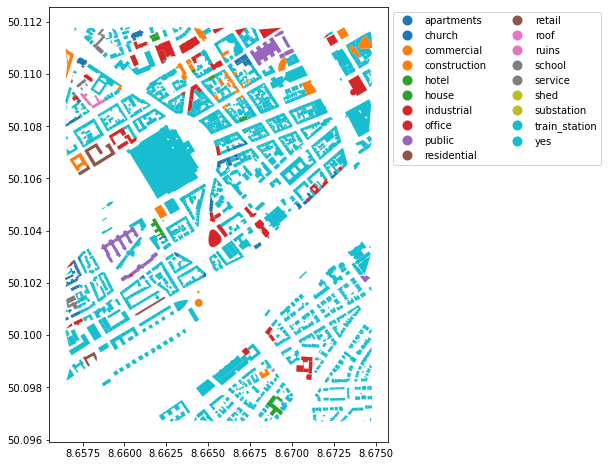

In [135]:
for i in [fp_rotterdam, fp_munich, fp_zurich, fp_hamburg, fp_frankfurt]:
    # Initiliaze with bounding box
    osm = py.OSM(filepath=i)

    # Read POIs with custom filter 
    my_filter={'building': True} #"amenity": True, 'shop': True, }
    pois = osm.get_pois(custom_filter=my_filter)
    #print (pois.head(10))
    # Merge poi type information into a single column
    #pois["shop"] = pois["shop"].fillna(' ')
    #pois["amenity"] = pois["amenity"].fillna(' ')
    pois["building"] = pois["building"].fillna(' ')
    pois["poi_type"] = pois["building"] #+ pois["amenity"] + pois["shop"] 

    # Plot
    ax = pois.plot(column="poi_type", legend=True, markersize=4, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=2, bbox_to_anchor=(1, 1)))

# Plot techniques, eg hexbin or kde?

In [141]:
pois['x'] = pois.geometry.centroid.x
pois['y'] = pois.geometry.centroid.y


C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
C:\Users\koenv\miniconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [142]:
pois.head()

,lon,lat,id,timestamp,version,tags,changeset,addr:city,addr:housenumber,addr:postcode,...,height,internet_access,shop,source,start_date,wikipedia,poi_type,cent,x,y
0,8.660402,50.102287,1295171973,0,0,None,0.0,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,office,POINT (8.66040 50.10229),8.660402,50.102287
1,8.671494,50.107841,5352364983,-93,-80,"{""tourism"":""artwork""}",-97.0,Frankfurt am Main,8-12,60329,...,NaN,NaN,NaN,NaN,NaN,NaN,yes,POINT (8.67149 50.10784),8.671494,50.107841
2,8.662398,50.110504,5417049775,0,0,"{""tourism"":""yes""}",0.0,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,yes,POINT (8.66240 50.11050),8.662398,50.110504
3,NaN,NaN,11018162,1492634428,12,"{""wikidata"":""Q657979"",""building:part"":""yes""}",NaN,Frankfurt am Main,1,60325,...,155,None,None,None,1993,de:Westend Tower,office,POINT (8.66227 50.11067),8.662266,50.110675
4,NaN,NaN,11527028,1486570988,6,None,NaN,Frankfurt am Main,32-36,60311,...,None,None,None,None,None,None,commercial,POINT (8.67374 50.11088),8.673735,50.110879


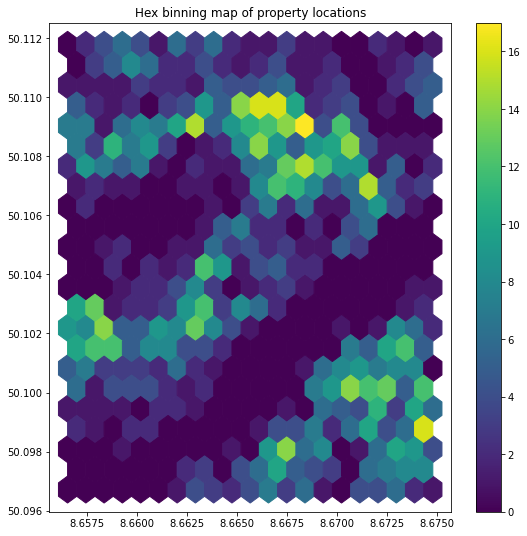

In [144]:
# create a hex binning map of the property locations
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(pois["x"], 
               pois["y"], 
               gridsize=20, 
              )
# Add a colorbar (optional)
ax.set_title('Hex binning map of property locations')
#ax.set_axis_off()
plt.colorbar(hb)

In [127]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

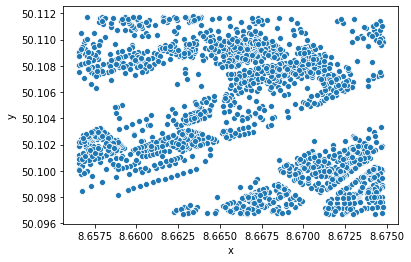

In [143]:
sns.scatterplot(x = 'x', y = 'y', data = pois)

In [12]:
# point to things
len (TranslateTable.road.unique()) # 57 roads measured

57

In [15]:
len(TranslateTable.detid.unique())

259

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:xlabel='long', ylabel='lat'>)

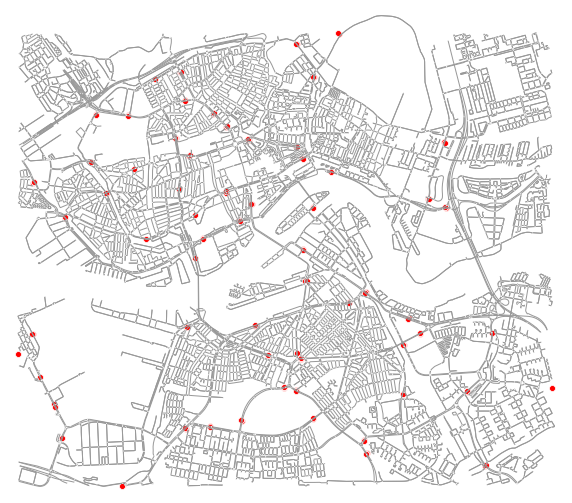

In [48]:
df2 = UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam']
f, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(x = 'long', y = 'lat', data = df2, ax=ax, color = 'red')
ox.plot_graph(Rotterdam, node_size=1, ax =ax, show = False, close = False)




In [66]:
tupLong = df2.iloc[0]['long']
tupLat = df2.iloc[0]['lat']

tup = (tupLat,tupLong)

ox.get_nearest_edge(Rotterdam, tup)

(44225957, 44238129, 0)

In [77]:
edge_attributes.loc[(edge_attributes.u == 44225957) & (edge_attributes.v == 44238129 )]

,osmid,name,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key
5590,7326943,Kreekhuizenlaan,secondary,True,391.22,NaN,"LINESTRING (4.53834 51.88361, 4.53852 51.88371...",50,NaN,S126,NaN,NaN,NaN,44225957,44238129,0


In [78]:
df2.iloc[0]['detid']

'GRT02_MORO_1811_2_1'

In [79]:
edge_attributes['detid'] = np.nan

In [85]:
edge_attributes.loc[(edge_attributes.u == 44225957) & (edge_attributes.v == 44238129 ),'detid'] = df2.iloc[0]['detid']

In [86]:
edge_attributes.iloc[5590]

osmid                                                 7326943
name                                          Kreekhuizenlaan
highway                                             secondary
oneway                                                   True
length                                                 391.22
bridge                                                    NaN
geometry    LINESTRING (4.5383376 51.8836142, 4.5385236 51...
maxspeed                                                   50
lanes                                                     NaN
ref                                                      S126
junction                                                  NaN
tunnel                                                    NaN
access                                                    NaN
u                                                    44225957
v                                                    44238129
key                                                         0
detid   

In [95]:
ox.get_nearest_edge?

Signature: ox.get_nearest_edge(G, point, return_geom=False, return_dist=False)
Docstring:
Return the nearest edge to a point, by minimum euclidean distance.

Parameters
----------
G : networkx.MultiDiGraph
    input graph
point : tuple
    the (lat, lng) or (y, x) point for which we will find the nearest edge
    in the graph
return_geom : bool
    Optionally return the geometry of the nearest edge
return_dist : bool
    Optionally return the distance in graph's coordinates' units between
    the point and the nearest edge

Returns
-------
tuple
    Graph edge unique identifier as a tuple of (u, v, key).
    Or a tuple of (u, v, key, geom) if return_geom is True.
    Or a tuple of (u, v, key, dist) if return_dist is True.
    Or a tuple of (u, v, key, geom, dist) if return_geom and return_dist are True.
File:      c:\users\koenv\miniconda3\envs\gds\lib\site-packages\osmnx\distance.py
Type:      function


In [121]:
def MatchDetID(Df, E_attributes, Graph):
    Df.reset_index(inplace = True, drop = True)
    E_attributes['detid'] = np.nan
    
    for i in Df.index:
        tupLong = Df.iloc[i]['long']
        tupLat = Df.iloc[i]['lat']
        tup = (tupLat,tupLong)

        u, v, key = ox.get_nearest_edge(Graph, tup)
        #edge_attributes.loc[(edge_attributes.u == 44225957) & (edge_attributes.v == 44238129 ),'detid'] = df2.iloc[0]['detid']
        E_attributes.loc[(E_attributes.u == u) & (E_attributes.v == v), 'detid'] = Df.iloc[i]['detid']
        
        #print (E_attributes.loc[(E_attributes.u == u) & (E_attributes.v == v), 'detid'])
    return E_attributes
    
x = MatchDetID(df2, edge_attributes, Rotterdam)

In [123]:
len (x.detid.unique())

120

In [124]:
ox.graph_from_gdfs(node_data, x, graph_attrs={})

Signature: ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=None)
Docstring:
Convert node and edge GeoDataFrames to a MultiDiGraph.

This function is the inverse of `graph_to_gdfs`.

Parameters
----------
gdf_nodes : geopandas.GeoDataFrame
    GeoDataFrame of graph nodes
gdf_edges : geopandas.GeoDataFrame
    GeoDataFrame of graph edges, must have crs attribute set
graph_attrs : dict
    the new G.graph attribute dict; if None, add crs as the only
    graph-level attribute

Returns
-------
G : networkx.MultiDiGraph
File:      c:\users\koenv\miniconda3\envs\gds\lib\site-packages\osmnx\utils_graph.py
Type:      function


,osmid,name,highway,oneway,length,bridge,geometry,maxspeed,lanes,ref,junction,tunnel,access,u,v,key,detid
2545,48400943,Kreekhuizenlaan,secondary,True,392.592,NaN,"LINESTRING (4.54245 51.88607, 4.54228 51.88600...",50,NaN,S126,NaN,NaN,NaN,44239512,44226441,0,NaN
3956,7326948,Kreekhuizenlaan,secondary,True,233.342,NaN,"LINESTRING (4.53651 51.88194, 4.53652 51.88210...",50,NaN,S126,NaN,NaN,NaN,603623370,44225957,0,NaN
5589,7326613,Kreekhuizenlaan,tertiary,False,17.181,NaN,"LINESTRING (4.53834 51.88361, 4.53817 51.88373)",50,NaN,NaN,NaN,NaN,NaN,44225957,44226441,0,NaN
5590,7326943,Kreekhuizenlaan,secondary,True,391.220,NaN,"LINESTRING (4.53834 51.88361, 4.53852 51.88371...",50,NaN,S126,NaN,NaN,NaN,44225957,44238129,0,GRT02_MORO_1811_2_1
6101,7326613,Kreekhuizenlaan,tertiary,False,17.181,NaN,"LINESTRING (4.53817 51.88373, 4.53834 51.88361)",50,NaN,NaN,NaN,NaN,NaN,44226441,44225957,0,NaN
6103,7326947,Kreekhuizenlaan,secondary,True,248.196,NaN,"LINESTRING (4.53817 51.88373, 4.53799 51.88362...",50,NaN,S126,NaN,NaN,NaN,44226441,44218065,0,NaN
